In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools
import pickle

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D
from matplotlib_venn import venn3, venn3_circles

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


In [3]:
import parsl
parsl.clear()

#from polyfuse.configs.igsb import config
from polyfuse.configs.igsb_jupyter import config
parsl.load(config)

from polyfuse import modeling, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
model_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/models'
data_dir = '/cephfs/users/annawoodard/fusion-simulation/data/processed/'
training_fraction = 0.85

In [5]:
truth = modeling.concatenate_true_fusions(os.path.join(data_dir, '*'), out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
truth

,gene_id_pair,left_gene_id,right_gene_id,left_gene_name,right_gene_name,fusion,sample
0,ENSG00000196155.13--ENSG00000138757.14,ENSG00000196155.13,ENSG00000138757.14,AC040160.1,G3BP2,AC040160.1--G3BP2,LIB-03335WT
1,ENSG00000254206.5--ENSG00000127580.17,ENSG00000254206.5,ENSG00000127580.17,NPIPB11,WDR24,NPIPB11--WDR24,LIB-03335WT
2,ENSG00000284776.1--ENSG00000114638.8,ENSG00000284776.1,ENSG00000114638.8,AL121900.1,UPK1B,AL121900.1--UPK1B,LIB-03335WT
3,ENSG00000069345.12--ENSG00000124449.7,ENSG00000069345.12,ENSG00000124449.7,DNAJA2,IRGC,DNAJA2--IRGC,LIB-03335WT
4,ENSG00000248099.4--ENSG00000261459.1,ENSG00000248099.4,ENSG00000261459.1,INSL3,AC002310.4,INSL3--AC002310.4,LIB-03335WT
...,...,...,...,...,...,...,...
495,ENSG00000089775.11--ENSG00000168427.9,ENSG00000089775.11,ENSG00000168427.9,ZBTB25,KLHL30,ZBTB25--KLHL30,LIB-006806wt
496,ENSG00000283992.2--ENSG00000134744.14,ENSG00000283992.2,ENSG00000134744.14,SLURP2,TUT4,SLURP2--TUT4,LIB-006806wt
497,ENSG00000172350.10--ENSG00000143195.13,ENSG00000172350.10,ENSG00000143195.13,ABCG4,ILDR2,ABCG4--ILDR2,LIB-006806wt
498,ENSG00000142684.9--ENSG00000124743.6,ENSG00000142684.9,ENSG00000124743.6,ZNF593,KLHL31,ZNF593--KLHL31,LIB-006806wt


In [8]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [9]:
parsed_caller_data = modeling.parse_caller_data(out_dir, callers)

In [10]:
caller_data_path = modeling.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [11]:
samples = sorted(caller_data['sample'].unique())
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [15]:
start = time.time()
x_train, y_train = modeling.extract_features(training_samples, callers, out_dir)
print('extracted features in {:.1f}s'.format((time.time() - start)))

extracted features in 113.6s


fit models in 185.3s


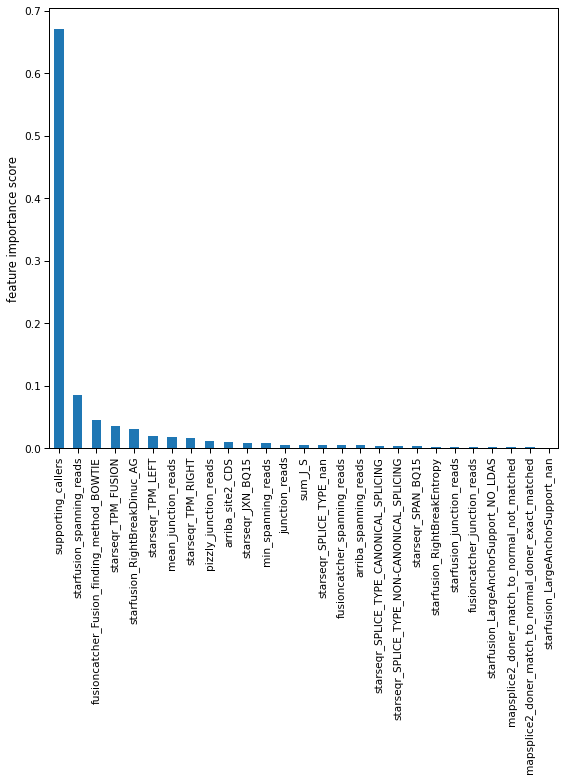

In [16]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = ['mean_spanning_reads', 'mean_junction_reads']
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
# below give 5 missing cancer cell line fusions compared with 7
#optimized_features = [
#    'starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads',
#    'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads',
#    'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads',
#    'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads',
#    'mapsplice2_junction_reads', 'starfusion_FFPM', 'starfusion_RightBreakEntropy', 'arriba_coverage1', 'arriba_coverage2', 'arriba_confidence_low'
#]
optimized_features = [
    'mean_spanning_reads', 'mean_junction_reads', 'fusioncatcher_spanning_reads', 
    'pizzly_called', 'pizzly_junction_reads', 'starseqr_OVERHANG_BQ15', 'starseqr_TPM_FUSION', 
    'starseqr_TPM_LEFT', 'starseqr_TPM_RIGHT', 'sum_J_S', 'fusioncatcher_Fusion_finding_method_BOWTIE', 
    'starseqr_FUSION_CLASS_nan', 'starseqr_SPLICE_TYPE_CANONICAL_SPLICING', 
    'mapsplice2_doner_match_to_normal_doner_exact_matched', 'starfusion_SpliceType_ONLY_REF_SPLICE', 
    'arriba_site1_CDS', 'arriba_site2_CDS', 'arriba_type_translocation'
]
optimized_features = [
    'mean_spanning_reads', 'mean_junction_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 
    'pizzly_called', 'pizzly_junction_reads', 'starseqr_OVERHANG_BQ15', 'starseqr_TPM_FUSION', 'starseqr_TPM_LEFT', 
    'starseqr_TPM_RIGHT', 'sum_J_S', 'fusioncatcher_Fusion_finding_method_BOWTIE', 
    'starseqr_SPLICE_TYPE_CANONICAL_SPLICING', 'starseqr_SPLICE_TYPE_nan', 'starfusion_LeftBreakDinuc_GT', 
    'starfusion_RightBreakDinuc_AG', 'arriba_site1_CDS', 'arriba_site2_CDS', 'arriba_type_translocation'
]
optimized_features = [
    'mean_spanning_reads', 'mean_junction_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 
    'pizzly_called', 'pizzly_junction_reads', 'starseqr_OVERHANG_BQ15', 'starseqr_TPM_FUSION', 'starseqr_TPM_LEFT', 
    'starseqr_TPM_RIGHT', 'sum_J_S', 'fusioncatcher_Fusion_finding_method_BOWTIE', 
    'starseqr_SPLICE_TYPE_CANONICAL_SPLICING', 'starseqr_SPLICE_TYPE_nan', 'starfusion_LeftBreakDinuc_GT', 
    'starfusion_RightBreakDinuc_AG', 'arriba_site1_CDS', 'arriba_site2_CDS', 'arriba_type_translocation',
    'supporting_callers', 'max_junction_reads', 'min_junction_reads', 'max_spanning_reads', 'min_spanning_reads'
]
optimized_features = ['mean_junction_reads', 'min_spanning_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads', 'pizzly_junction_reads', 'junction_reads', 'starseqr_SPAN_BQ15', 'starseqr_JXN_BQ15', 'starseqr_TPM_FUSION', 'starseqr_TPM_LEFT', 'starseqr_TPM_RIGHT', 'starfusion_RightBreakEntropy', 'sum_J_S', 'supporting_callers', 'fusioncatcher_Fusion_finding_method_BOWTIE', 'starseqr_SPLICE_TYPE_CANONICAL_SPLICING', 'starseqr_SPLICE_TYPE_NON-CANONICAL_SPLICING', 'starseqr_SPLICE_TYPE_nan', 'mapsplice2_doner_match_to_normal_doner_exact_matched', 'mapsplice2_doner_match_to_normal_not_matched', 'starfusion_LargeAnchorSupport_NO_LDAS', 'starfusion_LargeAnchorSupport_nan', 'starfusion_RightBreakDinuc_AG', 'arriba_site2_CDS']
classifiers = []
for features in [
            #base_columns,
            optimized_features
        ]:
#     label = 'DefaultSVC{}F'.format(len(features))
#     trans = 'flatten'
#     classifier = svm.SVC(probability=True)
#     classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
#     joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
#     classifiers += [(features, label, trans)]

#     label = 'SVC{}F'.format(len(features))
#     trans = 'flatten'
#     classifier = svm.SVC(C=10, gamma='auto', probability=True)
#     classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
#     joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
#     classifiers += [(features, label, trans)]
    
#     label = 'RFC{}F'.format(len(features))
#     trans = 'noop'
#     classifier = ensemble.RandomForestClassifier()
#     classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
#     joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
#     classifiers += [(features, label, trans)]

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(model_dir, label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure(figsize=(8, 11))
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')
    plt.savefig('plots/GBC_feature_importances.pdf')
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [31]:
# adapted from: https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 14)

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


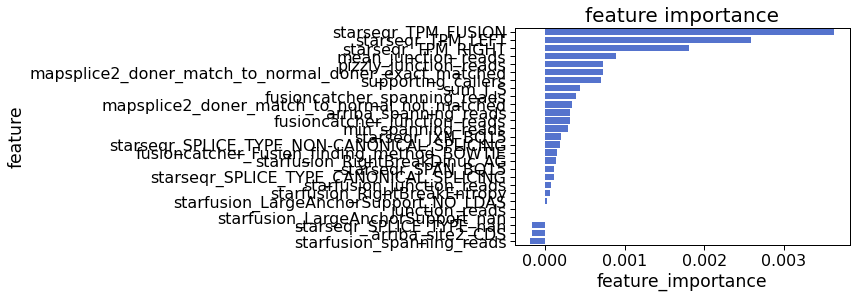

In [29]:

from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

drop_imp = drop_col_feat_imp(classifier, x_train[features], y_train)
var_imp_plot(drop_imp, 'feature importance')

In [30]:
drop_imp

,feature,feature_importance
0,starseqr_TPM_FUSION,3.634e-03
1,starseqr_TPM_LEFT,2.589e-03
2,starseqr_TPM_RIGHT,1.809e-03
3,mean_junction_reads,8.890e-04
4,pizzly_junction_reads,7.330e-04
5,mapsplice2_doner_match_to_normal_doner_exact_matched,7.330e-04
6,supporting_callers,7.019e-04
7,sum_J_S,4.367e-04
8,fusioncatcher_spanning_reads,3.899e-04
9,mapsplice2_doner_match_to_normal_not_matched,3.431e-04


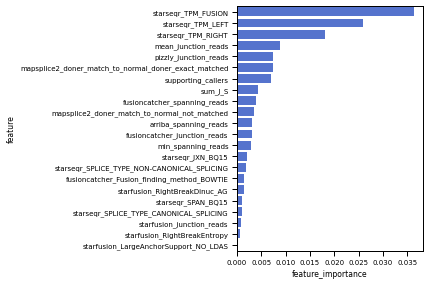

In [60]:
sns.set_context('paper', font_scale=0.8)
imp_df.columns = ['feature', 'feature_importance']

p = sns.barplot(x = 'feature_importance', y = 'feature', data = di, orient = 'h', color = 'royalblue')
plt.savefig('plots/GBC_feature_importances.pdf')

In [49]:
di = drop_imp[drop_imp.feature_importance > 0]
#di.feature_importance = [round(x, 2) for x in di.feature_importance]

In [58]:
di.feature_importance = di.feature_importance * 10

/cephfs/users/annawoodard/.local/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
foo = drop_imp.copy()

In [17]:
with open(os.path.join(model_dir, 'classifiers.pkl'), 'wb') as f:
    pickle.dump(classifiers, f)

In [18]:
start = time.time()
consensus_data = pd.read_hdf(
    modeling.predict_consensus(testing_samples, out_dir, callers, [2, 3, 4, 5, 6, 7]), 'data'
)
print('assembled consensus predictions in {:.1f}s'.format((time.time() - start)))

start = time.time()
consensus = ['ConsensusQ5', 'ConsensusQ4', 'ConsensusQ3']
model_data = pd.read_hdf(
    modeling.predict(testing_samples, out_dir, model_dir, classifiers, callers, consensus=consensus), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled consensus predictions in 1.0s
assembled predictions in 54.4s


In [19]:
summary = modeling.make_summary(out_dir, testing_samples)

trimmed_summary = summary
for caller in summary.caller.unique():
    if 'Consensus' in caller and caller not in ['ConsensusQ{}PolyfuseGBC18F'.format(i) for i in range(6)]:
        trimmed_summary = trimmed_summary[trimmed_summary.caller != caller]

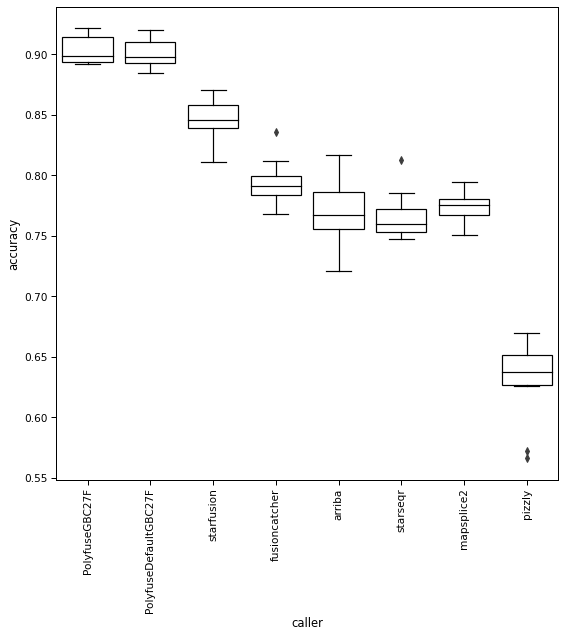

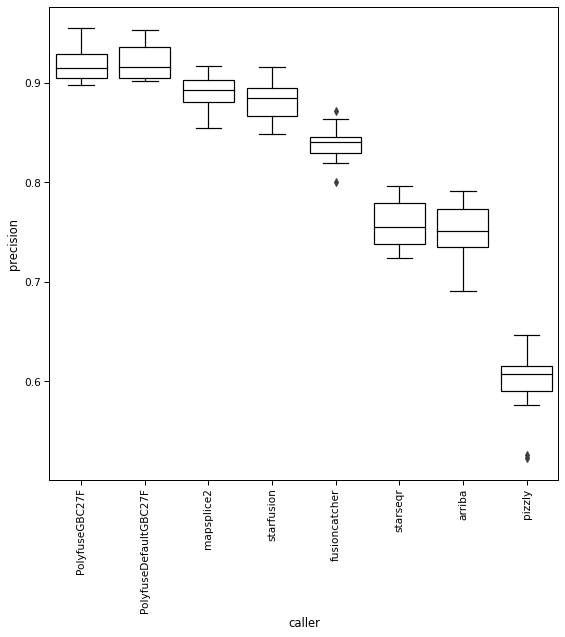

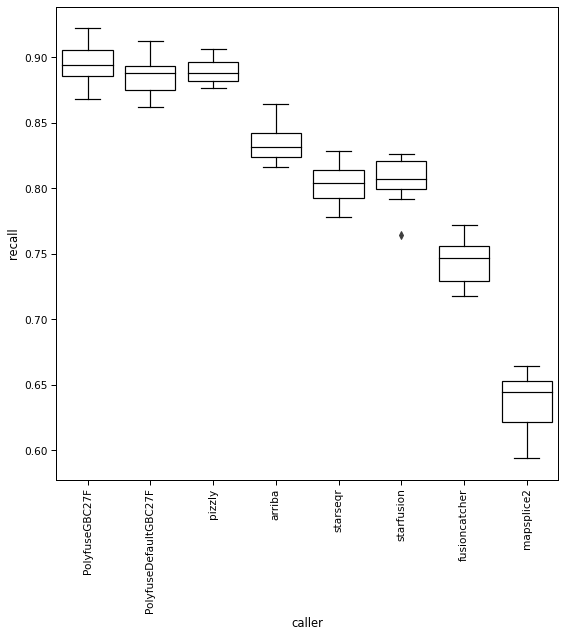

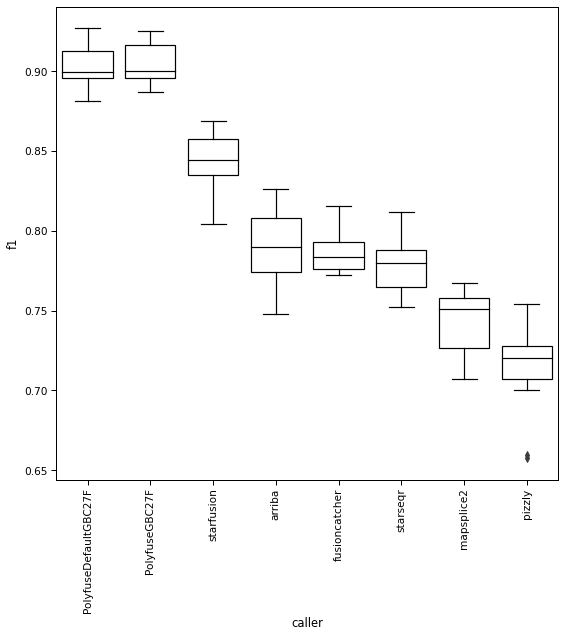

In [20]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure(figsize=(8, 9))
    #plt.figure()
    #sorted_index = summary[metric].median().sort_values().index
    #print(sorted_index)
    ax = sns.boxplot(x="caller", y=metric, data=trimmed_summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

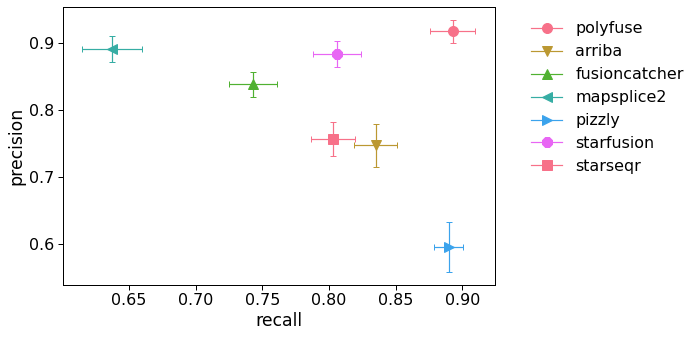

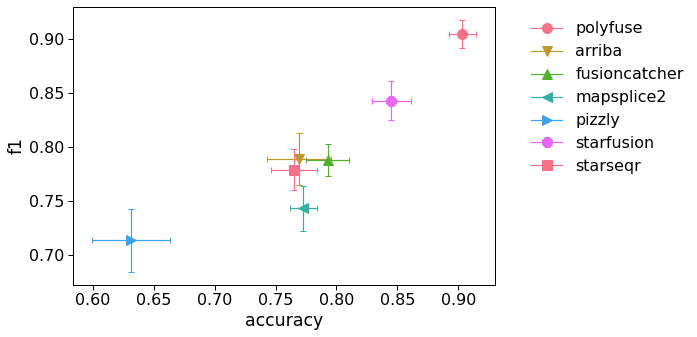

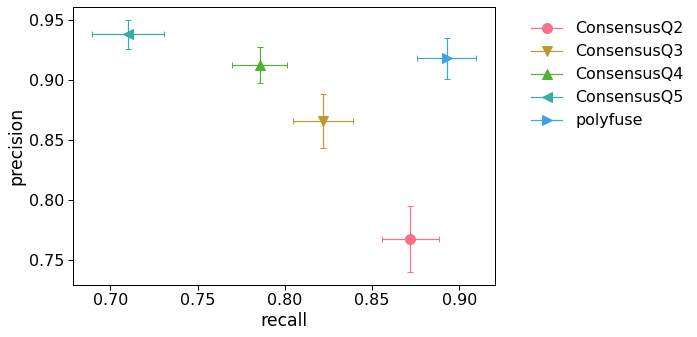

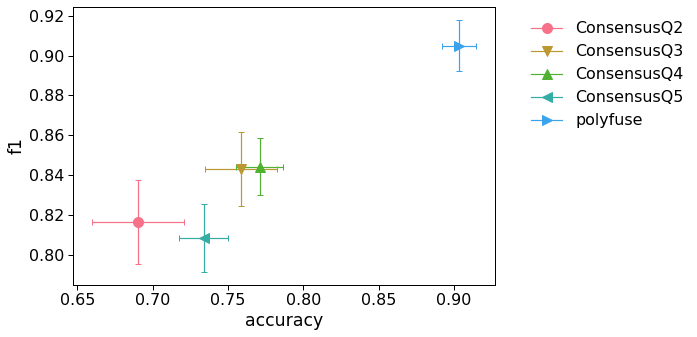

In [27]:
sns.set_context('paper', font_scale=1.8)

#markers = itertools.cycle(Line2D.filled_markers)
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D'))

sns.set_palette(sns.diverging_palette(145, 280, s=85, l=25, n=8, center='dark'))
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=9, center='dark'))
sns.set_palette("husl")

model_label = 'PolyfuseGBC{}F'.format(len(optimized_features))
for caller_set, tag in [
        (callers + [model_label], 'callers'),
        (['ConsensusQ{}'.format(i) for i in range(1, 6)] + [model_label], 'consensus')
    ]:

    top_model_summary = summary[summary.caller.isin(caller_set)]
    means = top_model_summary.groupby('caller').mean()
    stds = top_model_summary.groupby('caller').std()
    markers = itertools.cycle(Line2D.filled_markers[:len(means)])

    for x, y in [('recall', 'precision'), ('accuracy', 'f1')]:
        fig, ax = plt.subplots(figsize=(10, 5))

        for caller in means.index:
            plt.errorbar(
                [means.loc[caller][x]],
                [means.loc[caller][y]],
                xerr=stds.loc[caller][x],
                yerr=stds.loc[caller][y],
                label=caller if caller != model_label else 'polyfuse',
                marker=next(markers),
                markersize=10,
                capsize=3
            )
        
        plt.xlabel(x)
        plt.ylabel(y)
        handles, labels = ax.get_legend_handles_labels()
        handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False)
        #plt.tight_layout()
        plt.savefig('plots/{}_vs_{}_{}.pdf'.format(x, y, tag))
    

In [22]:
pd.options.display.max_rows = 200
print('number of testing samples: {}'.format(len(testing_samples)))
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

number of testing samples: 12


,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC27F,446.417,40.083,53.583,429.917,0.893,0.918,0.904,0.905,0.807
PolyfuseDefaultGBC27F,442.250,38.000,57.750,432.000,0.884,0.921,0.901,0.902,0.803
ConsensusQ5PolyfuseGBC27F,448.500,45.083,51.500,424.917,0.897,0.909,0.901,0.903,0.801
ConsensusQ5PolyfuseDefaultGBC27F,443.750,42.167,56.250,427.833,0.888,0.913,0.899,0.900,0.797
ConsensusQ4PolyfuseGBC27F,449.833,52.500,50.167,417.500,0.900,0.896,0.894,0.898,0.788
ConsensusQ4PolyfuseDefaultGBC27F,445.583,49.083,54.417,420.917,0.891,0.901,0.893,0.896,0.786
ConsensusQ3PolyfuseGBC27F,453.583,74.333,46.417,395.667,0.907,0.859,0.876,0.883,0.751
ConsensusQ3PolyfuseDefaultGBC27F,450.167,71.000,49.833,399.000,0.900,0.864,0.876,0.882,0.751
starfusion,403.083,53.167,96.917,416.833,0.806,0.884,0.845,0.843,0.693


In [23]:
summary.sort_values(by='accuracy', ascending=False)

,sample,caller,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
52,LIB-04653wt,PolyfuseGBC27F,446,21,54,434,0.892,0.955,0.921,0.922,0.845
1,LIB-04650wt,PolyfuseDefaultGBC27F,446,31,54,532,0.892,0.935,0.920,0.913,0.840
8,LIB-04657wt,PolyfuseDefaultGBC27F,456,28,44,365,0.912,0.942,0.919,0.927,0.838
4,LIB-04653wt,PolyfuseDefaultGBC27F,444,22,56,433,0.888,0.953,0.918,0.919,0.839
49,LIB-04650wt,PolyfuseGBC27F,454,41,46,522,0.908,0.917,0.918,0.913,0.836
...,...,...,...,...,...,...,...,...,...,...,...
156,LIB-04649wt,pizzly,442,287,58,143,0.884,0.606,0.629,0.719,0.262
158,LIB-04651wt,pizzly,446,328,54,195,0.892,0.576,0.627,0.700,0.309
167,LIB-04674wt,pizzly,440,300,60,162,0.880,0.595,0.626,0.710,0.274
159,LIB-04652wt,pizzly,439,396,61,173,0.878,0.526,0.572,0.658,0.220


PolyfuseDefaultGBC27F
ConsensusQ5PolyfuseDefaultGBC27F
ConsensusQ4PolyfuseDefaultGBC27F
ConsensusQ3PolyfuseDefaultGBC27F
PolyfuseGBC27F
ConsensusQ5PolyfuseGBC27F
ConsensusQ4PolyfuseGBC27F
ConsensusQ3PolyfuseGBC27F


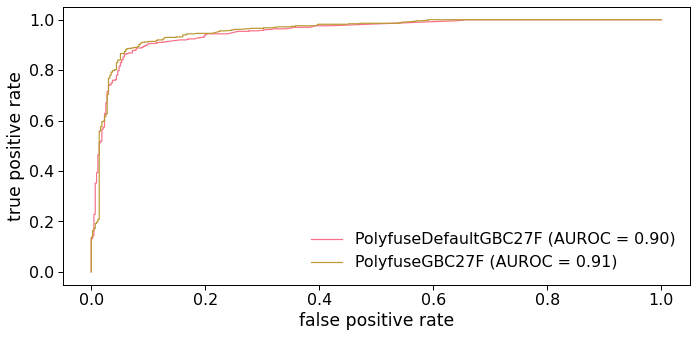

In [24]:
sample = model_data['sample'].unique()[0]
plt.figure(figsize=(10,5))
trimmed_summary = summary

for caller in model_data.caller.unique():
    print(caller)
    if 'Consensus' in caller and caller not in ['ConsensusQ{}PolyfuseGBC19F'.format(i) for i in range(6)]:
        continue
    try:
        y_true, y_pred, y_prob = modeling.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)
plt.savefig('plots/ROC.pdf')

PolyfuseDefaultGBC27F
ConsensusQ5PolyfuseDefaultGBC27F
ConsensusQ4PolyfuseDefaultGBC27F
ConsensusQ3PolyfuseDefaultGBC27F
PolyfuseGBC27F
ConsensusQ5PolyfuseGBC27F
ConsensusQ4PolyfuseGBC27F
ConsensusQ3PolyfuseGBC27F


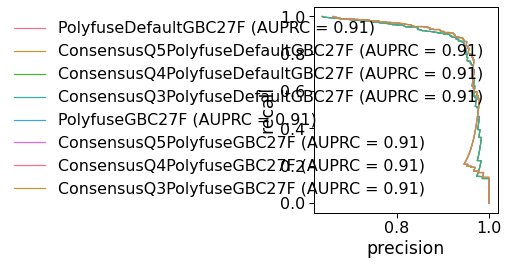

In [25]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = modeling.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [26]:
from polyfuse.utils import get_consensus

data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]
callsets = []
futures = []
for caller in callers:
    callsets.append(set(cut_data[cut_data.caller == caller].fusion))
for quorum in [1, 2, 3, 4, 5, 6, 7]:
    futures += [(get_consensus(callsets, quorum), quorum)]

In [35]:
for f, quorum in futures:
    consensus = f.result()
    print(len(consensus), quorum)

905 1
566 2
483 3
434 4
386 5
0 6
0 7
